In [41]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [42]:
# Reading the data from the csv file
data = pd.read_csv('GPSapps/googleplaystore.csv')

In [43]:
# Clean 'Installs' column: Remove '+' and ',' and convert to numeric
data['Installs'] = data['Installs'].str.replace('[+,]', '', regex=True)
data['Installs'] = pd.to_numeric(data['Installs'], errors='coerce')  # Convert to numeric, invalid values to NaN

# Clean 'Reviews' column: Convert to numeric
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')  # Convert to numeric, invalid values to NaN

# Clean 'Size' column: Standardize sizes and handle 'Varies with device'
def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', '')) * 1_000_000  # Convert MB to bytes
    elif 'K' in size:
        return float(size.replace('K', '')) * 1_000  # Convert KB to bytes
    elif size == 'Varies with device':
        return np.nan  # Assign NaN for non-specific sizes
    else:
        return np.nan  # Catch-all for invalid entries

data['Size'] = data['Size'].apply(convert_size)

# Handle missing values in 'Rating': Fill with median as an initial approach
data['Rating'].fillna(data['Rating'].median(), inplace=True)

# Display the cleaned data types and any remaining missing values
data.info()
data[['Installs', 'Reviews', 'Size', 'Rating']].describe()  # Summary statistics for cleaned columnsfiltered_data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          10841 non-null  float64
 3   Reviews         10840 non-null  float64
 4   Size            8829 non-null   float64
 5   Installs        10840 non-null  float64
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(4), object(9)
memory usage: 1.1+ MB


/tmp/ipykernel_4812/1511163945.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Rating'].fillna(data['Rating'].median(), inplace=True)


,Installs,Reviews,Size,Rating
count,1.084000e+04,1.084000e+04,8.829000e+03,10841.000000
mean,1.546434e+07,4.441529e+05,2.227054e+07,4.207841
std,8.502936e+07,2.927761e+06,2.262869e+07,0.500893
min,0.000000e+00,0.000000e+00,1.000000e+06,1.000000
25%,1.000000e+03,3.800000e+01,5.400000e+06,4.100000
50%,1.000000e+05,2.094000e+03,1.400000e+07,4.300000
75%,5.000000e+06,5.477550e+04,3.100000e+07,4.500000
max,1.000000e+09,7.815831e+07,1.000000e+08,19.000000


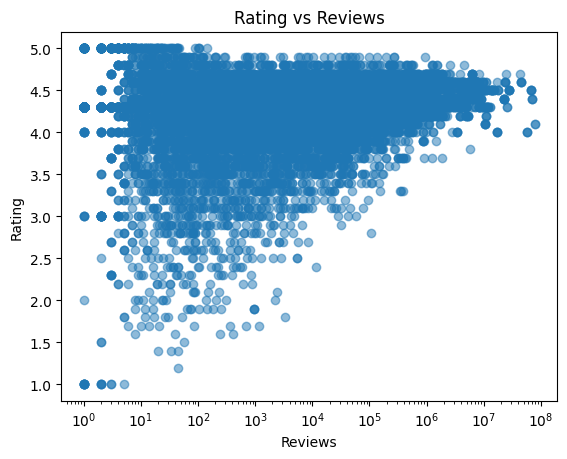

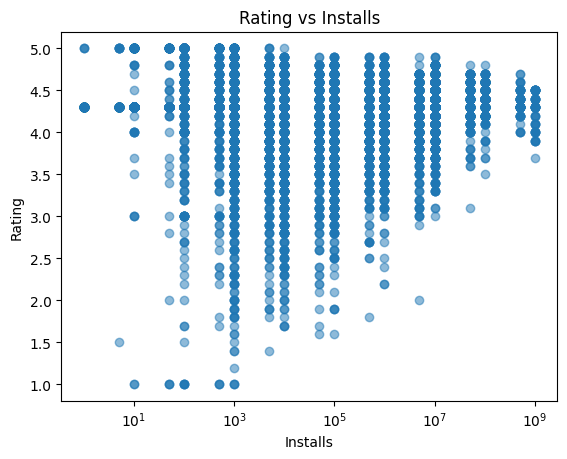

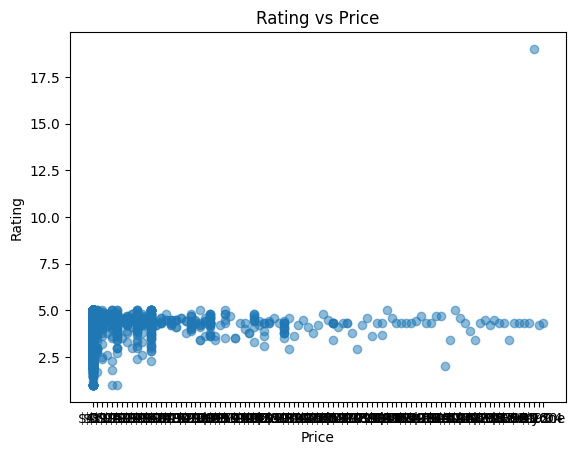

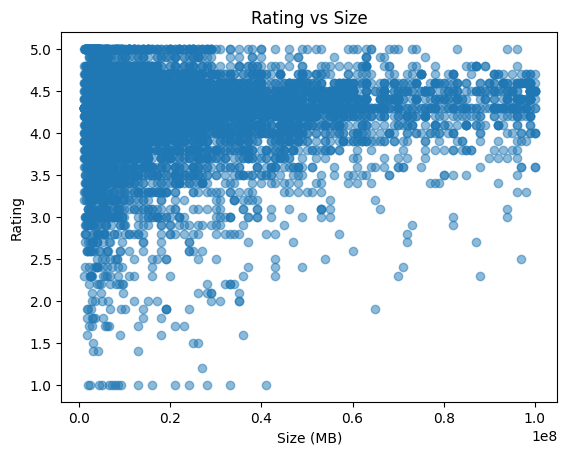

In [44]:
# Scatter plot for Rating vs Reviews
plt.scatter(data['Reviews'], data['Rating'], alpha=0.5)
plt.xscale('log')  # Log scale for Reviews
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.title('Rating vs Reviews')
plt.show()

# Scatter plot for Rating vs Installs
plt.scatter(data['Installs'], data['Rating'], alpha=0.5)
plt.xscale('log')  # Log scale for Installs
plt.xlabel('Installs')
plt.ylabel('Rating')
plt.title('Rating vs Installs')
plt.show()

# Scatter plot for Rating vs Price
plt.scatter(data['Price'], data['Rating'], alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Rating')
plt.title('Rating vs Price')
plt.show()

# Scatter plot for Rating vs Size
plt.scatter(data['Size'], data['Rating'], alpha=0.5)
plt.xlabel('Size (MB)')
plt.ylabel('Rating')
plt.title('Rating vs Size')
plt.show()


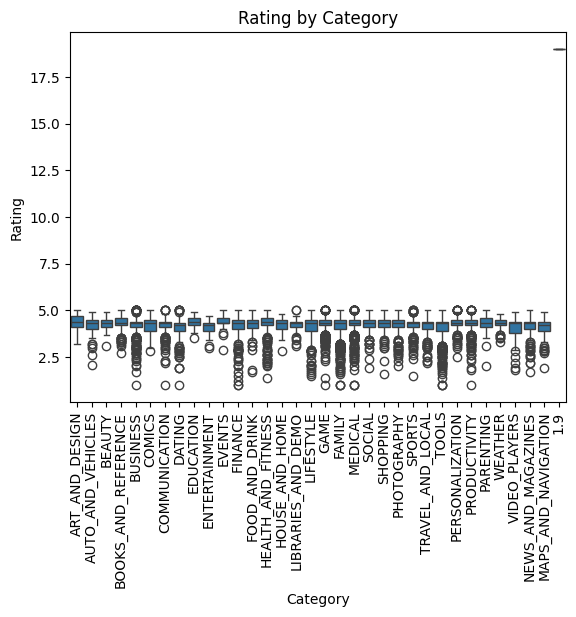

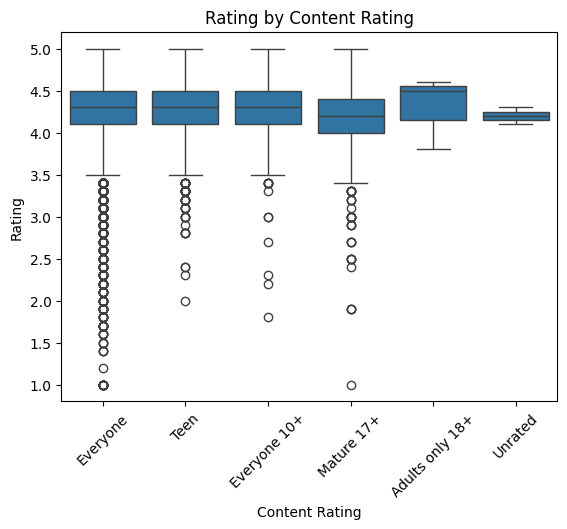

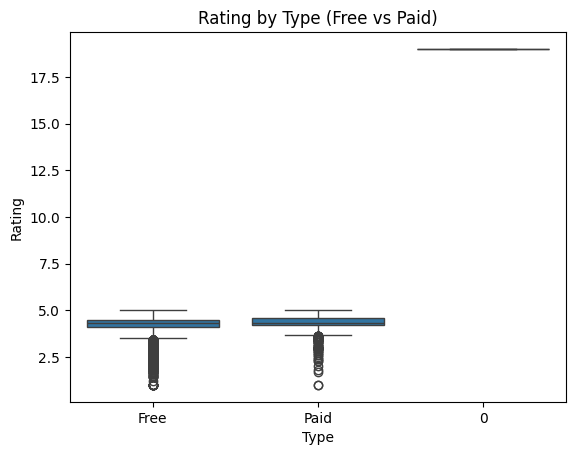

In [45]:
# Box plot for Rating vs Category
sns.boxplot(x='Category', y='Rating', data=data)
plt.xticks(rotation=90)  # Rotate category labels
plt.title('Rating by Category')
plt.show()

# Box plot for Rating vs Content Rating
sns.boxplot(x='Content Rating', y='Rating', data=data)
plt.xticks(rotation=45)
plt.title('Rating by Content Rating')
plt.show()

# Box plot for Rating vs Type (Free vs Paid)
sns.boxplot(x='Type', y='Rating', data=data)
plt.title('Rating by Type (Free vs Paid)')
plt.show()

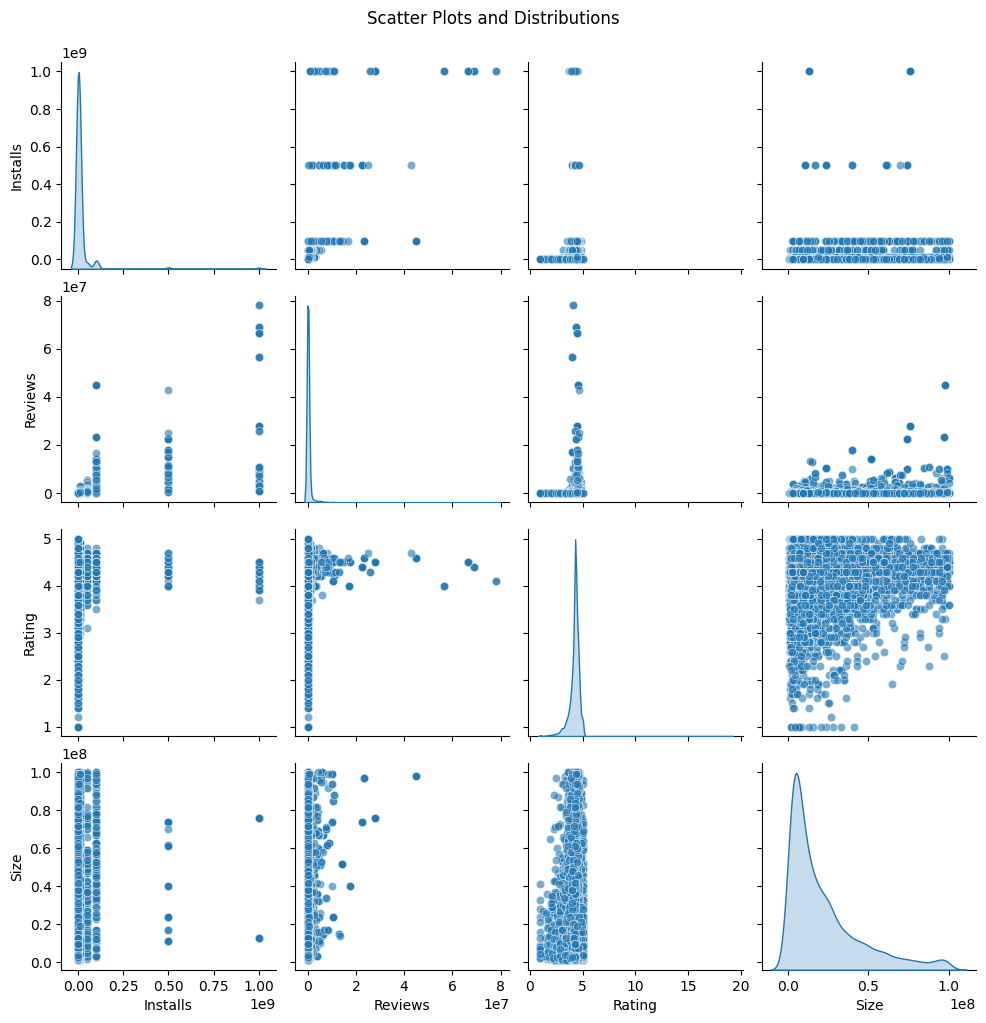

In [46]:
# Create scatter plots for numeric columns
sns.pairplot(data, vars=['Installs', 'Reviews', 'Rating', 'Size'], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Scatter Plots and Distributions', y=1.02)
plt.show()

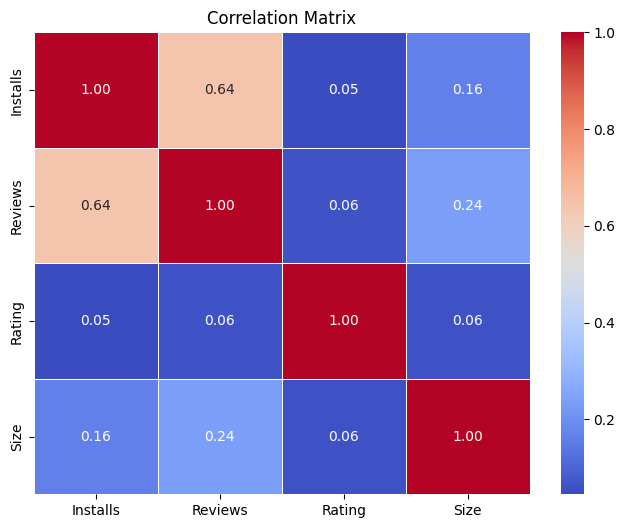

In [47]:
# Compute correlation matrix and visualize as a heatmap
correlation_matrix = data[['Installs', 'Reviews', 'Rating', 'Size']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [53]:
# Removing outliers

# Calculate IQR for relevant columns
Q1_installs = data['Installs'].quantile(0.25)
Q3_installs = data['Installs'].quantile(0.75)
IQR_installs = Q3_installs - Q1_installs

Q1_reviews = data['Reviews'].quantile(0.25)
Q3_reviews = data['Reviews'].quantile(0.75)
IQR_reviews = Q3_reviews - Q1_reviews

Q1_size = data['Size'].quantile(0.25)
Q3_size = data['Size'].quantile(0.75)
IQR_size = Q3_size - Q1_size

# Define outlier thresholds for each column
lower_bound_installs = Q1_installs - 1.5 * IQR_installs
upper_bound_installs = Q3_installs + 1.5 * IQR_installs

lower_bound_reviews = Q1_reviews - 1.5 * IQR_reviews
upper_bound_reviews = Q3_reviews + 1.5 * IQR_reviews

lower_bound_size = Q1_size - 1.5 * IQR_size
upper_bound_size = Q3_size + 1.5 * IQR_size

# Filter out outliers
filtered_data = data[
    (data['Installs'] >= lower_bound_installs) & (data['Installs'] <= upper_bound_installs) &
    (data['Reviews'] >= lower_bound_reviews) & (data['Reviews'] <= upper_bound_reviews) &
    (data['Size'] >= lower_bound_size) & (data['Size'] <= upper_bound_size)
]

# Display the data without outliers
print(filtered_data.head())


                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   
5                         Paper flowers instructions  ART_AND_DESIGN     4.4   

    Reviews      Size  Installs  Type Price Content Rating  \
0 -0.151657 -0.144539 -0.181761  Free     0       Everyone   
1 -0.151381 -0.365510 -0.175998  Free     0       Everyone   
2 -0.121820 -0.599739 -0.123073  Free     0       Everyone   
4 -0.151381 -0.860485 -0.180703  Free     0       Everyone   
5 -0.151654 -0.736741 -0.181291  Free     0       Everyone   

                      Genres      Last Updated Current Ver   Android Ver  
0               Art & Design   January 7, 2018       1.0.0  4.0.3 and u

In [55]:
# Standardize the data

# Create a StandardScaler instance
scaler = StandardScaler()

# Select the columns to standardize
columns_to_standardize = ['Installs', 'Reviews', 'Size']

# Fit and transform the selected columns
filtered_data[columns_to_standardize] = scaler.fit_transform(filtered_data[columns_to_standardize])

# Display the standardized data
print(filtered_data.head())


                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   
5                         Paper flowers instructions  ART_AND_DESIGN     4.4   

    Reviews      Size  Installs  Type Price Content Rating  \
0 -0.441752  0.143112 -0.377673  Free     0       Everyone   
1 -0.408267 -0.180842 -0.128499  Free     0       Everyone   
2  3.178307 -0.524234  2.159827  Free     0       Everyone   
4 -0.408267 -0.906501 -0.331906  Free     0       Everyone   
5 -0.441421 -0.725086 -0.357332  Free     0       Everyone   

                      Genres      Last Updated Current Ver   Android Ver  
0               Art & Design   January 7, 2018       1.0.0  4.0.3 and u

/tmp/ipykernel_4812/1708936331.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[columns_to_standardize] = scaler.fit_transform(filtered_data[columns_to_standardize])


In [57]:
# Step 1: Define the features (X) and the target variable (y)
# Let's predict 'Installs' based on 'Reviews' and 'Size'
X = filtered_data[['Reviews', 'Size']]  # Features
y = filtered_data['Installs']           # Target variable (Installs)

# Step 2: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create the Linear Regression model
model = LinearRegression()

# Step 4: Fit the model to the training data
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)              # R-squared value

# Print the performance metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Display the coefficients and intercept of the model
print(f"Model Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_}")

Mean Squared Error: 0.48886613900750425
R-squared: 0.4944807849917128
Model Coefficients: [ 0.73825777 -0.02300211]
Model Intercept: -0.0026262032806259033


In [58]:
# Step 1: Define the features (X) and the target variable (y)
# Let's predict 'Reviews' based on 'Installs' and 'Size'
X = filtered_data[['Installs', 'Size']]  # Features
y = filtered_data['Reviews']           # Target variable (Installs)

# Step 2: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create the Linear Regression model
model = LinearRegression()

# Step 4: Fit the model to the training data
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)              # R-squared value

# Print the performance metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Display the coefficients and intercept of the model
print(f"Model Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_}")

Mean Squared Error: 0.45446476218447723
R-squared: 0.49469083559523475
Model Coefficients: [0.73479378 0.10183086]
Model Intercept: 0.004411408252266262


In [59]:
# Import required libraries

import statsmodels.api as sm



# Select all columns except excluded ones and 'Installs' (target)

X_full = filtered_data.drop(columns=['Installs', 'App', 'Last Updated', 'Current Ver', 'Android Ver'])



# Convert categorical variables into dummy/indicator variables

X_full = pd.get_dummies(X_full, drop_first=True)



# Target variable

y = filtered_data['Installs']



# Add a constant term for the regression model

X_full = sm.add_constant(X_full)



# Fit the regression model using OLS (Ordinary Least Squares)
data.dtypes
# model = sm.OLS(y, X_full).fit()



# Summary of the regression model

model_summary = model.summary()

model_summary

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).